In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model

In [2]:
data = pd.read_csv('LFP(1-21).csv')
data

,Unnamed: 0,Cycle,V_m,Current(A),Cap,SoC,SoH,SoHcyc,deltaV
0,0,1,3.584,4.990,0.001386,99.998668,0.001386,104.094819,0.000
1,1,1,3.583,4.993,0.002773,99.997336,0.002773,104.094819,0.001
2,2,1,3.580,4.994,0.004160,99.996004,0.004160,104.094819,0.004
3,3,1,3.579,4.996,0.005548,99.994670,0.005548,104.094819,0.005
4,4,1,3.577,4.993,0.006935,99.993338,0.006935,104.094819,0.007
...,...,...,...,...,...,...,...,...,...
1555936,1555936,21,2.801,4.999,102.288321,1.740326,102.288321,102.293879,0.765
1555937,1555937,21,2.802,4.999,102.289710,1.738992,102.289710,102.293879,0.764
1555938,1555938,21,2.802,4.999,102.291098,1.737658,102.291098,102.293879,0.764
1555939,1555939,21,2.801,5.001,102.292488,1.736323,102.292488,102.293879,0.765


In [3]:
data.loc[data['Cycle'] == 5]

,Unnamed: 0,Cycle,V_m,Current(A),Cap,SoC,SoH,SoHcyc,deltaV
299478,299478,5,3.587,4.990,0.001386,99.998668,0.001386,103.841841,0.000
299479,299479,5,3.586,4.985,0.002771,99.997338,0.002771,103.841841,0.001
299480,299480,5,3.583,4.988,0.004156,99.996007,0.004156,103.841841,0.004
299481,299481,5,3.580,4.985,0.005541,99.994677,0.005541,103.841841,0.007
299482,299482,5,3.580,4.988,0.006927,99.993346,0.006927,103.841841,0.007
...,...,...,...,...,...,...,...,...,...
374261,374261,5,2.801,4.996,103.836287,0.253327,103.836287,103.841841,0.786
374262,374262,5,2.801,4.999,103.837675,0.251993,103.837675,103.841841,0.786
374263,374263,5,2.800,4.999,103.839064,0.250659,103.839064,103.841841,0.787
374264,374264,5,2.800,4.999,103.840453,0.249325,103.840453,103.841841,0.787


In [4]:
X=data[['V_m','Cap','deltaV','SoC']]
y=data['SoH'].values
std=StandardScaler()
X_std=std.fit_transform(X)

train_size=int(0.7*len(X_std))
test_size=int(0.9*len(X_std))
X_train=X_std[:train_size]
X_val=X_std[train_size:test_size]
X_test=X_std[test_size:]

X_train=X_train.reshape(-1,1,4)
X_val=X_val.reshape(-1,1,4)
X_test=X_test.reshape(-1,1,4)

y_train=y[:train_size]
y_val=y[train_size:test_size]
y_test=y[test_size:]

y_train=y_train.reshape(-1,1,1)
y_val=y_val.reshape(-1,1,1)
y_test=y_test.reshape(-1,1,1)

In [7]:
output_layers=1
model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(8,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu'),
    tf.keras.layers.Dense(output_layers,activation='linear')
])
print(model.summary())
print('\n')

model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.1),metrics=['mae','mse'])
history=model.fit(X_train,y_train,
                  epochs=40,
                  batch_size=100,
                  verbose=1,
                  steps_per_epoch=50,
                  validation_data=(X_val,y_val),
                  validation_steps=50,
                  validation_batch_size=150
                 )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 104       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/40
50/50 [==============================] - 5s 60ms/step - loss: 2071.4641 - mae: 36.0679 - mse: 2071.4641 - val_loss: 47.0057 - val_mae: 6.8141 - val_mse: 47.0057
Epoch 2/40
50/50 [==============================] - 0s 5ms/step - loss: 23.5186 - mae: 3.1520 - mse: 23.5186 - val_loss: 4.2918 - val_mae: 2.0613 - val_mse: 4.2918
Epoch 3/40
50/50 [==============================] - 0s 6ms/step - loss: 4.0453 - mae: 1.3073 - mse: 4.0453 - val_loss: 0.4796 - val_mae: 0.6863 - val_mse: 0.4796
Epoch 4/40
50/5

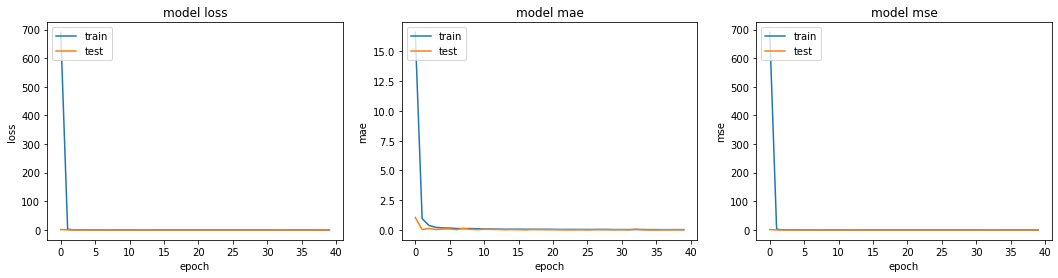

In [9]:
fig,ax=pl.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['loss','mae','mse']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('model {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'test'], loc='upper left')

In [10]:
model.save('SoH_LFP.RNN')

INFO:tensorflow:Assets written to: SoH_LFP.RNN\assets


In [11]:
model=load_model('SoH_LFP.RNN')

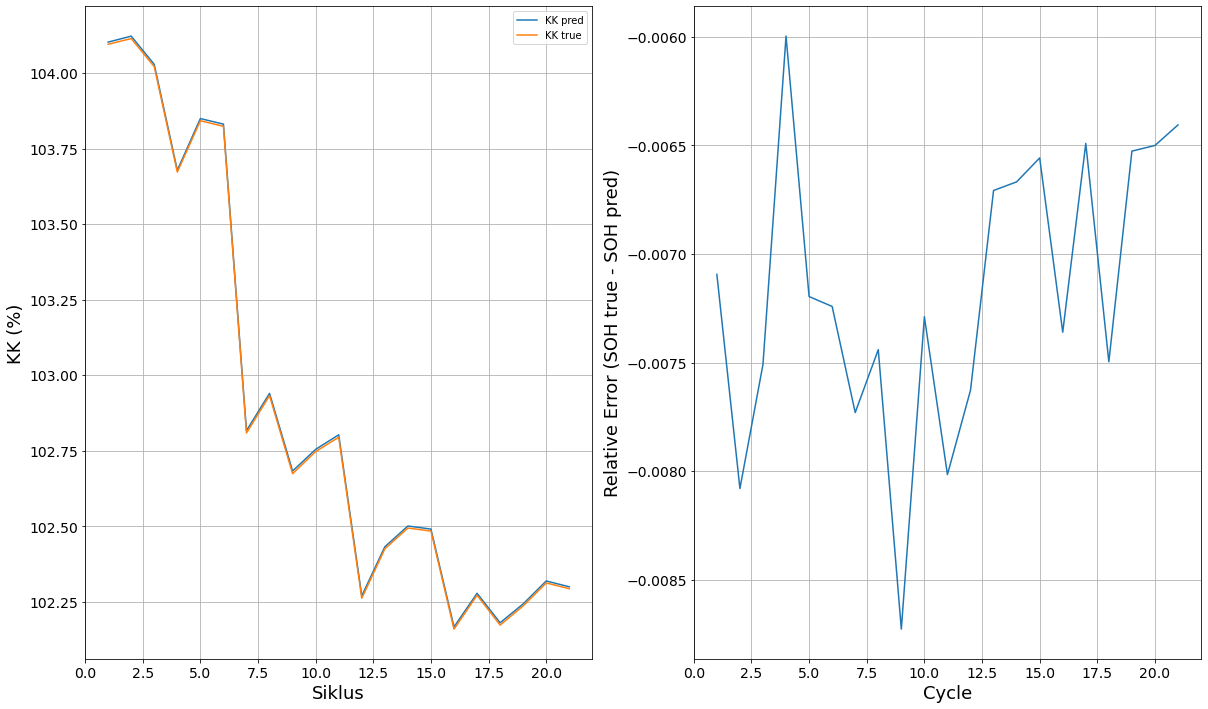

In [15]:
y_pred_all=model.predict(X_std.reshape(-1,1,4)).reshape(-1)
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(20,12))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoH,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoH-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SOH true - SOH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

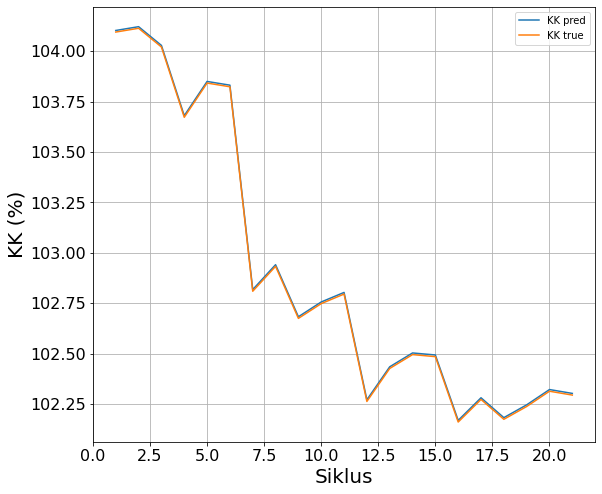

In [66]:
fig,ax=pl.subplots(figsize=(9,8))
ax.plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax.plot(cyc_dat.Cycle,cyc_dat.SoH,label='KK true')
ax.set_xlabel('Siklus')
ax.set_ylabel('KK (%)')
ax.legend()
ax.grid()


pl.rcParams['axes.labelsize'] = 20
pl.rcParams['xtick.labelsize'] = 16
pl.rcParams['ytick.labelsize'] = 16

In [13]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

MAE=mean_absolute_error(y,y_pred_all)
RMSE=sqrt(mean_squared_error(y,y_pred_all))
Skor=r2_score(y,y_pred_all)
def mape(y, y_pred_all): 
    y, y_pred_all = np.array(y), np.array(y_pred_all)
    return np.mean(np.abs((y - y_pred_all) / y)) * 100

print('Score prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)
print('MAPE prekdisi =',mape(y, y_pred_all) )

Score prediksi/estimasi pada data tes= 0.9999996185650832
MAE prekdisi/estimasi pada data tes= 0.00516629244103228
RMSE prekdisi/estimasi pada data tes= 0.01834589796202748
MAPE prekdisi = 0.26853665472359


# Validasi (5-12)

In [17]:
data = pd.read_csv('LFP(1-21).csv')
data

,Unnamed: 0,Cycle,V_m,Current(A),Cap,SoC,SoH,SoHcyc,deltaV
0,0,1,3.584,4.990,0.001386,99.998668,0.001386,104.094819,0.000
1,1,1,3.583,4.993,0.002773,99.997336,0.002773,104.094819,0.001
2,2,1,3.580,4.994,0.004160,99.996004,0.004160,104.094819,0.004
3,3,1,3.579,4.996,0.005548,99.994670,0.005548,104.094819,0.005
4,4,1,3.577,4.993,0.006935,99.993338,0.006935,104.094819,0.007
...,...,...,...,...,...,...,...,...,...
1555936,1555936,21,2.801,4.999,102.288321,1.740326,102.288321,102.293879,0.765
1555937,1555937,21,2.802,4.999,102.289710,1.738992,102.289710,102.293879,0.764
1555938,1555938,21,2.802,4.999,102.291098,1.737658,102.291098,102.293879,0.764
1555939,1555939,21,2.801,5.001,102.292488,1.736323,102.292488,102.293879,0.765


In [18]:
data = data.loc[(data['Cycle'] >= 5) & (data['Cycle'] <= 12)]
data

,Unnamed: 0,Cycle,V_m,Current(A),Cap,SoC,SoH,SoHcyc,deltaV
299478,299478,5,3.587,4.990,0.001386,99.998668,0.001386,103.841841,0.000
299479,299479,5,3.586,4.985,0.002771,99.997338,0.002771,103.841841,0.001
299480,299480,5,3.583,4.988,0.004156,99.996007,0.004156,103.841841,0.004
299481,299481,5,3.580,4.985,0.005541,99.994677,0.005541,103.841841,0.007
299482,299482,5,3.580,4.988,0.006927,99.993346,0.006927,103.841841,0.007
...,...,...,...,...,...,...,...,...,...
892764,892764,12,2.800,5.001,102.256811,1.770595,102.256811,102.262369,0.800
892765,892765,12,2.801,4.999,102.258200,1.769261,102.258200,102.262369,0.799
892766,892766,12,2.801,5.002,102.259589,1.767926,102.259589,102.262369,0.799
892767,892767,12,2.800,5.006,102.260980,1.766590,102.260980,102.262369,0.800


In [115]:
deltaV = []

for cid in data.Cycle.unique():
    dat_cid = data[data.Cycle==cid]
    deltaV += list(np.abs(dat_cid['V_m'] - dat_cid['V_m'].iloc[0]))

data['deltaV'] = deltaV
data

,Unnamed: 0,Cycle,V_m,Current(A),Cap,SoC,SoH,SoHcyc,deltaV
299478,299478,5,3.587,4.990,0.001386,99.998668,0.001386,103.841841,0.000
299479,299479,5,3.586,4.985,0.002771,99.997338,0.002771,103.841841,0.001
299480,299480,5,3.583,4.988,0.004156,99.996007,0.004156,103.841841,0.004
299481,299481,5,3.580,4.985,0.005541,99.994677,0.005541,103.841841,0.007
299482,299482,5,3.580,4.988,0.006927,99.993346,0.006927,103.841841,0.007
...,...,...,...,...,...,...,...,...,...
892764,892764,12,2.800,5.001,102.256811,1.770595,102.256811,102.262369,0.800
892765,892765,12,2.801,4.999,102.258200,1.769261,102.258200,102.262369,0.799
892766,892766,12,2.801,5.002,102.259589,1.767926,102.259589,102.262369,0.799
892767,892767,12,2.800,5.006,102.260980,1.766590,102.260980,102.262369,0.800


In [19]:
X=data[['V_m','Cap','deltaV','SoC']]
y=data['SoH']
std=StandardScaler()
X_std=std.fit_transform(X)

<ipython-input-20-a147be7b854f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOH_pred']=y_pred_all
<ipython-input-20-a147be7b854f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['selisih']=0
<ipython-input-20-a147be7b854f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

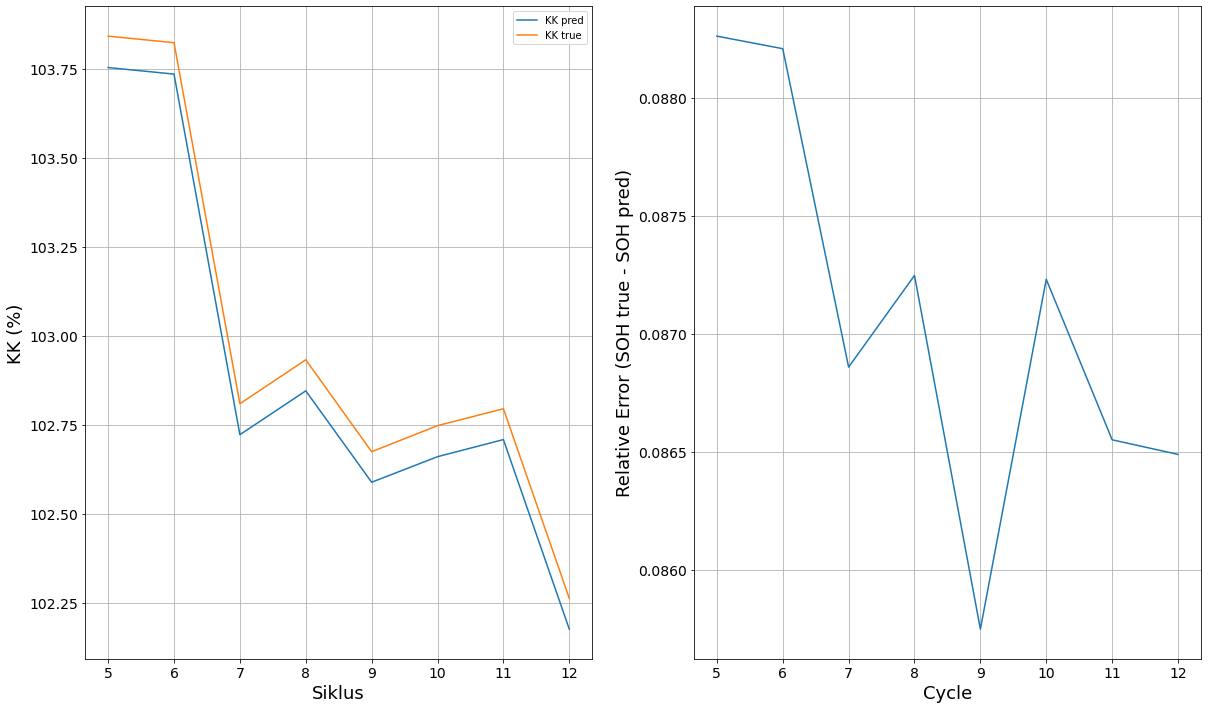

In [20]:
y_pred_all=model.predict(X_std.reshape(-1,1,4)).reshape(-1)
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(20,12))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoH,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(102,105)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoH-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SOH true - SOH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

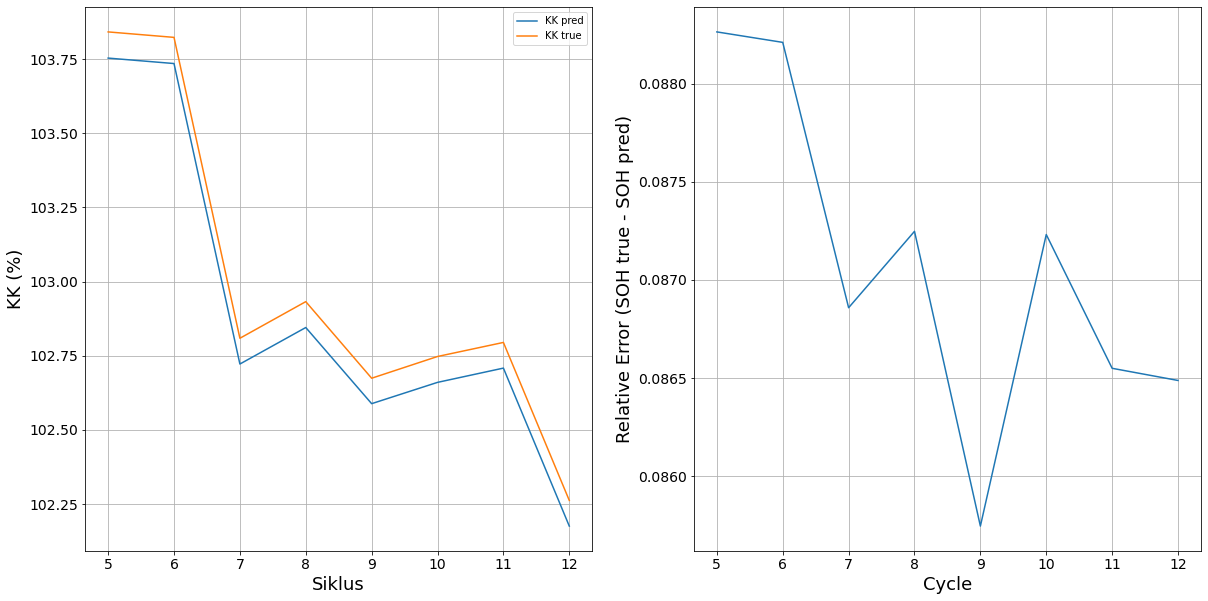

In [22]:
fig,ax=pl.subplots(1,2,figsize=(20,10))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoH,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(102,105)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoH-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SOH true - SOH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

In [124]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

MAE=mean_absolute_error(y,y_pred_all)
RMSE=sqrt(mean_squared_error(y,y_pred_all))
Skor=r2_score(y,y_pred_all)
def mape(y, y_pred_all): 
    y, y_pred_all = np.array(y), np.array(y_pred_all)
    return np.mean(np.abs((y - y_pred_all) / y)) * 100

print('Score prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)
print('MAPE prekdisi =',mape(y, y_pred_all) )

Score prediksi/estimasi pada data tes= 0.9999922317410704
MAE prekdisi/estimasi pada data tes= 0.06529603349176058
RMSE prekdisi/estimasi pada data tes= 0.08286368006175687
MAPE prekdisi = 0.8250907420373651
